In [ ]:
!pip install gymnasium[atari] --quiet
!pip install gymnasium --quiet
!pip install -U gymnasium[atari] --quiet
!pip install imageio_ffmpeg --quiet
!pip install npy_append_array --quiet
!pip install pyTelegramBotAPI --quiet
!pip install gymnasium[accept-rom-license] --quiet
!pip install gymnasium[box2d] --quiet

In [2]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Conv2D, Input
 
class ActorNetwork(tf.keras.Model):
    def __init__(self, input_didims, action_dim=1):
        super(ActorNetwork, self).__init__()
        self.fc1 = Dense(512, activation="relu", input_shape=input_dims, kernel_initializer="he_uniform")
        self.fc2 = Dense(256, activation="relu", kernel_initializer="he_uniform")
        self.fc2 = Dense(64, activation="relu", kernel_initializer="he_uniform")
        self.fc3 = Dense(action_dim, activation="softmax")

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


class CriticNetwork(tf.keras.Model):
    def __init__(self, input_dims, action_dim=1):
        super(CriticNetwork, self).__init__()
        self.fc1 = Dense(512, activation="relu", input_shape=input_dims, kernel_initializer="he_uniform")
        self.fc2 = Dense(256, activation="relu", kernel_initializer="he_uniform")
        self.fc2 = Dense(64, activation="relu", kernel_initializer="he_uniform")
        self.fc3 = Dense(1)

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [3]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf 
import tensorflow_probability as tfp
import numpy as np

class ActorCriticAgent:
  
  def __init__(self, input_dims, out_dims, gamma, lr1, lr2, action_space, batch_size, chkpt, algo_name): 
    self.gamma = gamma 
    self.batch_size = batch_size 
    self.action_space = action_space 
    self.action = None  
    self.fname = chkpt + '_' + algo_name 
    self.actor_network = ActorNetwork(input_dims, out_dims)
    self.actor_network.compile(optimizer=Adam(learning_rate=lr1))
    self.critic_network = CriticNetwork(input_dims, out_dims)
    self.critic_network.compile(optimizer=Adam(learning_rate=lr2))


  def get_action(self, state): 
    state = tf.convert_to_tensor(np.array(state).reshape(1, -1))
    action_probs = self.actor_network(state)[0]
    action_probs = tfp.distributions.Categorical(probs=action_probs)
    action = action_probs.sample()
    self.action = action
    return action.numpy()
 

  def save_models(self):
    self.actor_network.save(self.fname + "_" + "actor_network")
    self.critic_network.save(self.fname + "_" + "critic_network")
    print("[+] Saving the model")


  def load_models(self):
    self.actor_network = tf.keras.models.load_model(self.fname + "_" + "actor_network") 
    self.critic_network = tf.keras.models.load_model(self.fname + "_" + "critic_network") 
    print("[+] Loading the model")
  
  
  def learn(self, state, action, reward, next_state, done): 
    
    state = tf.convert_to_tensor(np.array(state).reshape(1, -1))
    next_state = tf.convert_to_tensor(np.array(next_state).reshape(1, -1))    
    td_target = None
    
    with tf.GradientTape() as tape: 
      value = self.critic_network(state)
      next_state_value = self.critic_network(next_state, training=True)
      critic_loss, td = self.critic_loss(value, reward, next_state_value, self.gamma, done)

    td_target = td
    critic_params = self.critic_network.trainable_variables 
    critic_grads = tape.gradient(critic_loss, critic_params)
    self.critic_network.optimizer.apply_gradients(zip(critic_grads, critic_params))

    with tf.GradientTape() as tape: 
      action_probs = self.actor_network(state)
      actor_loss = self.actor_loss(action_probs, action, td_target)

    actor_params = self.actor_network.trainable_variables
    actor_grads = tape.gradient(actor_loss, actor_params)

    self.actor_network.optimizer.apply_gradients(zip(actor_grads, actor_params))  
  

  def actor_loss(self, action_probs, action, td): 
    dist = tfp.distributions.Categorical(probs=action_probs, dtype=tf.float32)
    log_prob = dist.log_prob(action)
    loss = -log_prob * td
    return loss
  

  def critic_loss(self, value, reward, next_state_value, gamma, done): 
    td_target = reward + gamma * next_state_value * (1-int(done))
    delta = (td_target - value) ** 2 
    return delta, td_target
  

In [42]:
import collections
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf
from gymnasium.wrappers import *


def manage_memory():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


def plot_learning_curve(scores, figure_file):

    x = [_ for _ in range(len(scores))]
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg, label="Avg reward for agent", color="black")
    plt.plot(scores, label="Reward for agent", color="red")
    plt.xlabel("episodes")
    plt.ylabel("rewards")
    plt.title('Running average of previous 100 scores')
    plt.legend()
    plt.savefig(figure_file)


def make_env(env_name): 
    env = gym.make(env_name, render_mode="rgb_array")
    
    if len(env.observation_space.shape) >= 3: 
        #env = AtariPreprocessing(env, 10, 4, 84, False, True)
        env = ResizeObservation(env, 84)
        env = GrayScaleObservation(env, keep_dim=False)
        env = FrameStack(env, 4, lz4_compress=False)
        env = NormalizeObservation(env)

    return env

In [5]:
class Writer:
    def __init__(self, fname): 
        self.fname = fname 

    def write_to_file(self, content): 
        with open(self.fname, "a") as file: 
            file.write(content + "\n")

    def read_file(self, fname):
        with open(fname, "r") as file: 
            return file.read()
            

In [6]:
import time
from telebot import TeleBot
import datetime
import telebot

token = "6238487424:AAG0jRhvbiVa90qUcf2fAirQr_-quPMs7cU"
chat_id = "1055055706"
bot = TeleBot(token=token) 

def telegram_send(message, bot):
    chat_id = "1055055706"
    bot.send_message(chat_id=chat_id, text=message)

def welcome_msg(multi_step, double_dqn, dueling):
    st = 'Hi! Starting learning with DQN Multi-step = %d, Double DQN = %r, Dueling DQN = %r' % (multi_step, double_dqn, dueling)
    telegram_send(st, bot)
    
def info_msg(episode, max_episode, reward, best_score, loss): 
    st = f"Current Episode: {episode}, Current Reward: {reward}, Max Episode: {max_episode}, Best Score: {best_score}, loss: {loss}"
    telegram_send(st, bot)

def end_msg(learning_time):
    st = 'Finished! Learning time: ' + str(datetime.timedelta(seconds=int(learning_time)))
    telegram_send(st, bot)
    print(st)


In [7]:
import numpy as np 
import imageio


class RecordVideo: 
    
    def __init__(self, prefix_fname,  out_directory="videos/", fps=10): 
        self.prefix_fname = prefix_fname
        self.out_directory = out_directory
        self.fps = fps
        self.images = []
        
    def add_image(self, image): 
        self.images.append(image)
    
    def save(self, episode_no): 
        name = self.out_directory + self.prefix_fname + "_" + str(episode_no) + ".mp4"
        imageio.mimsave(name, [np.array(img) for i, img in enumerate(self.images)], fps=self.fps)
        self.images = []

In [8]:
class Trainer: 
  def __init__(self, env, action_space, input_dims, out_dims, video_prefix, is_tg, noe, max_steps, record, lr1, lr2, gamma, chkpt, algo_name): 
    self.env = env
    self.noe = noe 
    self.max_steps = max_steps 

    self.recorder = RecordVideo(video_prefix)
    self.is_tg = is_tg 
    self.record = record
    self.agent = ActorCriticAgent(input_dims, out_dims, gamma, lr1, lr2, action_space, 32, chkpt, algo_name)
    
  def train(self): 

    ep_rewards = []
    avg_rewards = []
    best_reward = float("-inf")

    for episode in range(self.noe): 
      state = self.env.reset()
      rewards = 0 

      if self.record and episode % 50 == 0: 
        img = self.env.render()
        self.recorder.add_image(img)

      for step in range(self.max_steps):
        
        if type(state) == tuple: 
          state = state[0]
       
        action = self.agent.get_action(state)

        next_info = self.env.step(action)

        next_state, reward_prob, terminated, truncated, _ = next_info 
        done = terminated or truncated 
        rewards += reward_prob

        self.agent.learn(state, action, reward_prob, next_state, done)

        state = next_state

        if self.record and episode % 50 == 0:
          img = self.env.render()
          self.recorder.add_image(img)

        if done: 
          break 
        
      if self.record and episode % 50 == 0:
        self.recorder.save(episode)

      if rewards > best_reward: 
        self.agent.save_models()
        best_reward = rewards

      ep_rewards.append(rewards)
      avg_reward = np.mean(ep_rewards[-100:])
      avg_rewards.append(avg_reward)
      print(f"Episode: {episode} Reward: {rewards} Best Score: {best_reward}, Average Reward: {avg_reward}")

    return ep_rewards, avg_rewards



(4,) 2


[+] Saving the model
Episode: 0 Reward: 11.0 Best Score: 11.0, Average Reward: 11.0
[+] Saving the model
Episode: 1 Reward: 15.0 Best Score: 15.0, Average Reward: 13.0
Episode: 2 Reward: 11.0 Best Score: 15.0, Average Reward: 12.333333333333334
Episode: 3 Reward: 10.0 Best Score: 15.0, Average Reward: 11.75
Episode: 4 Reward: 13.0 Best Score: 15.0, Average Reward: 12.0
Episode: 5 Reward: 10.0 Best Score: 15.0, Average Reward: 11.666666666666666
Episode: 6 Reward: 10.0 Best Score: 15.0, Average Reward: 11.428571428571429
Episode: 7 Reward: 11.0 Best Score: 15.0, Average Reward: 11.375
[+] Saving the model
Episode: 8 Reward: 17.0 Best Score: 17.0, Average Reward: 12.0
Episode: 9 Reward: 16.0 Best Score: 17.0, Average Reward: 12.4
[+] Saving the model
Episode: 10 Reward: 22.0 Best Score: 22.0, Average Reward: 13.272727272727273
Episode: 11 Reward: 15.0 Best Score: 22.0, Average Reward: 13.416666666666666
Episode: 12 Reward: 18.0 Best Score: 22.0, Average Reward: 13.76923076923077
Episode:

Episode: 50 Reward: 24.0 Best Score: 78.0, Average Reward: 21.901960784313726
Episode: 51 Reward: 18.0 Best Score: 78.0, Average Reward: 21.826923076923077
Episode: 52 Reward: 18.0 Best Score: 78.0, Average Reward: 21.754716981132077
Episode: 53 Reward: 10.0 Best Score: 78.0, Average Reward: 21.537037037037038
Episode: 54 Reward: 8.0 Best Score: 78.0, Average Reward: 21.29090909090909
Episode: 55 Reward: 8.0 Best Score: 78.0, Average Reward: 21.053571428571427
Episode: 56 Reward: 23.0 Best Score: 78.0, Average Reward: 21.087719298245613
Episode: 57 Reward: 17.0 Best Score: 78.0, Average Reward: 21.017241379310345
Episode: 58 Reward: 11.0 Best Score: 78.0, Average Reward: 20.847457627118644
Episode: 59 Reward: 10.0 Best Score: 78.0, Average Reward: 20.666666666666668
Episode: 60 Reward: 10.0 Best Score: 78.0, Average Reward: 20.491803278688526
Episode: 61 Reward: 12.0 Best Score: 78.0, Average Reward: 20.35483870967742
Episode: 62 Reward: 10.0 Best Score: 78.0, Average Reward: 20.190476

Episode: 100 Reward: 33.0 Best Score: 78.0, Average Reward: 18.29
Episode: 101 Reward: 12.0 Best Score: 78.0, Average Reward: 18.26
Episode: 102 Reward: 12.0 Best Score: 78.0, Average Reward: 18.27
Episode: 103 Reward: 12.0 Best Score: 78.0, Average Reward: 18.29
Episode: 104 Reward: 16.0 Best Score: 78.0, Average Reward: 18.32
Episode: 105 Reward: 10.0 Best Score: 78.0, Average Reward: 18.32
Episode: 106 Reward: 11.0 Best Score: 78.0, Average Reward: 18.33
Episode: 107 Reward: 9.0 Best Score: 78.0, Average Reward: 18.31
Episode: 108 Reward: 34.0 Best Score: 78.0, Average Reward: 18.48
Episode: 109 Reward: 10.0 Best Score: 78.0, Average Reward: 18.42
Episode: 110 Reward: 13.0 Best Score: 78.0, Average Reward: 18.33
Episode: 111 Reward: 10.0 Best Score: 78.0, Average Reward: 18.28
Episode: 112 Reward: 13.0 Best Score: 78.0, Average Reward: 18.23
Episode: 113 Reward: 11.0 Best Score: 78.0, Average Reward: 18.19
Episode: 114 Reward: 19.0 Best Score: 78.0, Average Reward: 18.03
Episode: 11

Episode: 150 Reward: 10.0 Best Score: 78.0, Average Reward: 14.27
Episode: 151 Reward: 26.0 Best Score: 78.0, Average Reward: 14.35
Episode: 152 Reward: 19.0 Best Score: 78.0, Average Reward: 14.36
Episode: 153 Reward: 9.0 Best Score: 78.0, Average Reward: 14.35
Episode: 154 Reward: 10.0 Best Score: 78.0, Average Reward: 14.37
Episode: 155 Reward: 18.0 Best Score: 78.0, Average Reward: 14.47
Episode: 156 Reward: 30.0 Best Score: 78.0, Average Reward: 14.54
Episode: 157 Reward: 9.0 Best Score: 78.0, Average Reward: 14.46
Episode: 158 Reward: 20.0 Best Score: 78.0, Average Reward: 14.55
Episode: 159 Reward: 12.0 Best Score: 78.0, Average Reward: 14.57
Episode: 160 Reward: 20.0 Best Score: 78.0, Average Reward: 14.67
Episode: 161 Reward: 12.0 Best Score: 78.0, Average Reward: 14.67
Episode: 162 Reward: 10.0 Best Score: 78.0, Average Reward: 14.67
Episode: 163 Reward: 10.0 Best Score: 78.0, Average Reward: 14.56
Episode: 164 Reward: 17.0 Best Score: 78.0, Average Reward: 14.64
Episode: 165

Episode: 200 Reward: 23.0 Best Score: 93.0, Average Reward: 16.61
Episode: 201 Reward: 9.0 Best Score: 93.0, Average Reward: 16.58
Episode: 202 Reward: 20.0 Best Score: 93.0, Average Reward: 16.66
Episode: 203 Reward: 25.0 Best Score: 93.0, Average Reward: 16.79
Episode: 204 Reward: 26.0 Best Score: 93.0, Average Reward: 16.89
Episode: 205 Reward: 73.0 Best Score: 93.0, Average Reward: 17.52
Episode: 206 Reward: 82.0 Best Score: 93.0, Average Reward: 18.23
Episode: 207 Reward: 25.0 Best Score: 93.0, Average Reward: 18.39
Episode: 208 Reward: 24.0 Best Score: 93.0, Average Reward: 18.29
Episode: 209 Reward: 18.0 Best Score: 93.0, Average Reward: 18.37
Episode: 210 Reward: 39.0 Best Score: 93.0, Average Reward: 18.63
Episode: 211 Reward: 32.0 Best Score: 93.0, Average Reward: 18.85
Episode: 212 Reward: 64.0 Best Score: 93.0, Average Reward: 19.36
Episode: 213 Reward: 30.0 Best Score: 93.0, Average Reward: 19.55
Episode: 214 Reward: 49.0 Best Score: 93.0, Average Reward: 19.85
Episode: 21

Episode: 250 Reward: 45.0 Best Score: 159.0, Average Reward: 33.09
Episode: 251 Reward: 77.0 Best Score: 159.0, Average Reward: 33.6
Episode: 252 Reward: 31.0 Best Score: 159.0, Average Reward: 33.72
Episode: 253 Reward: 28.0 Best Score: 159.0, Average Reward: 33.91
Episode: 254 Reward: 59.0 Best Score: 159.0, Average Reward: 34.4
Episode: 255 Reward: 32.0 Best Score: 159.0, Average Reward: 34.54
Episode: 256 Reward: 79.0 Best Score: 159.0, Average Reward: 35.03
Episode: 257 Reward: 41.0 Best Score: 159.0, Average Reward: 35.35
Episode: 258 Reward: 57.0 Best Score: 159.0, Average Reward: 35.72
Episode: 259 Reward: 45.0 Best Score: 159.0, Average Reward: 36.05
Episode: 260 Reward: 55.0 Best Score: 159.0, Average Reward: 36.4
Episode: 261 Reward: 36.0 Best Score: 159.0, Average Reward: 36.64
Episode: 262 Reward: 64.0 Best Score: 159.0, Average Reward: 37.18
Episode: 263 Reward: 38.0 Best Score: 159.0, Average Reward: 37.46
Episode: 264 Reward: 52.0 Best Score: 159.0, Average Reward: 37.8

Episode: 300 Reward: 28.0 Best Score: 159.0, Average Reward: 45.43
Episode: 301 Reward: 17.0 Best Score: 159.0, Average Reward: 45.51
Episode: 302 Reward: 53.0 Best Score: 159.0, Average Reward: 45.84
Episode: 303 Reward: 67.0 Best Score: 159.0, Average Reward: 46.26
Episode: 304 Reward: 19.0 Best Score: 159.0, Average Reward: 46.19
Episode: 305 Reward: 35.0 Best Score: 159.0, Average Reward: 45.81
Episode: 306 Reward: 48.0 Best Score: 159.0, Average Reward: 45.47
Episode: 307 Reward: 28.0 Best Score: 159.0, Average Reward: 45.5
Episode: 308 Reward: 42.0 Best Score: 159.0, Average Reward: 45.68
Episode: 309 Reward: 64.0 Best Score: 159.0, Average Reward: 46.14
Episode: 310 Reward: 55.0 Best Score: 159.0, Average Reward: 46.3
Episode: 311 Reward: 40.0 Best Score: 159.0, Average Reward: 46.38
Episode: 312 Reward: 42.0 Best Score: 159.0, Average Reward: 46.16
Episode: 313 Reward: 41.0 Best Score: 159.0, Average Reward: 46.27
Episode: 314 Reward: 36.0 Best Score: 159.0, Average Reward: 46.

Episode: 350 Reward: 64.0 Best Score: 159.0, Average Reward: 42.78
Episode: 351 Reward: 64.0 Best Score: 159.0, Average Reward: 42.65
Episode: 352 Reward: 46.0 Best Score: 159.0, Average Reward: 42.8
Episode: 353 Reward: 42.0 Best Score: 159.0, Average Reward: 42.94
Episode: 354 Reward: 51.0 Best Score: 159.0, Average Reward: 42.86
Episode: 355 Reward: 60.0 Best Score: 159.0, Average Reward: 43.14
Episode: 356 Reward: 25.0 Best Score: 159.0, Average Reward: 42.6
Episode: 357 Reward: 31.0 Best Score: 159.0, Average Reward: 42.5
Episode: 358 Reward: 33.0 Best Score: 159.0, Average Reward: 42.26
Episode: 359 Reward: 116.0 Best Score: 159.0, Average Reward: 42.97
Episode: 360 Reward: 85.0 Best Score: 159.0, Average Reward: 43.27
Episode: 361 Reward: 62.0 Best Score: 159.0, Average Reward: 43.53
Episode: 362 Reward: 65.0 Best Score: 159.0, Average Reward: 43.54
Episode: 363 Reward: 59.0 Best Score: 159.0, Average Reward: 43.75
Episode: 364 Reward: 44.0 Best Score: 159.0, Average Reward: 43.

Episode: 400 Reward: 78.0 Best Score: 177.0, Average Reward: 50.44
Episode: 401 Reward: 47.0 Best Score: 177.0, Average Reward: 50.74
Episode: 402 Reward: 43.0 Best Score: 177.0, Average Reward: 50.64
Episode: 403 Reward: 39.0 Best Score: 177.0, Average Reward: 50.36
Episode: 404 Reward: 35.0 Best Score: 177.0, Average Reward: 50.52
Episode: 405 Reward: 40.0 Best Score: 177.0, Average Reward: 50.57
Episode: 406 Reward: 66.0 Best Score: 177.0, Average Reward: 50.75
Episode: 407 Reward: 54.0 Best Score: 177.0, Average Reward: 51.01
Episode: 408 Reward: 77.0 Best Score: 177.0, Average Reward: 51.36
Episode: 409 Reward: 65.0 Best Score: 177.0, Average Reward: 51.37
Episode: 410 Reward: 82.0 Best Score: 177.0, Average Reward: 51.64
Episode: 411 Reward: 90.0 Best Score: 177.0, Average Reward: 52.14
Episode: 412 Reward: 52.0 Best Score: 177.0, Average Reward: 52.24
Episode: 413 Reward: 33.0 Best Score: 177.0, Average Reward: 52.16
Episode: 414 Reward: 22.0 Best Score: 177.0, Average Reward: 5

Episode: 450 Reward: 50.0 Best Score: 192.0, Average Reward: 60.85
Episode: 451 Reward: 57.0 Best Score: 192.0, Average Reward: 60.78
Episode: 452 Reward: 67.0 Best Score: 192.0, Average Reward: 60.99
Episode: 453 Reward: 52.0 Best Score: 192.0, Average Reward: 61.09
Episode: 454 Reward: 63.0 Best Score: 192.0, Average Reward: 61.21
Episode: 455 Reward: 15.0 Best Score: 192.0, Average Reward: 60.76
Episode: 456 Reward: 55.0 Best Score: 192.0, Average Reward: 61.06
Episode: 457 Reward: 49.0 Best Score: 192.0, Average Reward: 61.24
Episode: 458 Reward: 32.0 Best Score: 192.0, Average Reward: 61.23
Episode: 459 Reward: 44.0 Best Score: 192.0, Average Reward: 60.51
Episode: 460 Reward: 48.0 Best Score: 192.0, Average Reward: 60.14
Episode: 461 Reward: 38.0 Best Score: 192.0, Average Reward: 59.9
Episode: 462 Reward: 48.0 Best Score: 192.0, Average Reward: 59.73
Episode: 463 Reward: 83.0 Best Score: 192.0, Average Reward: 59.97
Episode: 464 Reward: 84.0 Best Score: 192.0, Average Reward: 60

Episode: 500 Reward: 77.0 Best Score: 192.0, Average Reward: 67.75
Episode: 501 Reward: 62.0 Best Score: 192.0, Average Reward: 67.9
Episode: 502 Reward: 79.0 Best Score: 192.0, Average Reward: 68.26
Episode: 503 Reward: 49.0 Best Score: 192.0, Average Reward: 68.36
Episode: 504 Reward: 44.0 Best Score: 192.0, Average Reward: 68.45
Episode: 505 Reward: 65.0 Best Score: 192.0, Average Reward: 68.7
Episode: 506 Reward: 45.0 Best Score: 192.0, Average Reward: 68.49
Episode: 507 Reward: 156.0 Best Score: 192.0, Average Reward: 69.51
Episode: 508 Reward: 163.0 Best Score: 192.0, Average Reward: 70.37
Episode: 509 Reward: 38.0 Best Score: 192.0, Average Reward: 70.1
Episode: 510 Reward: 68.0 Best Score: 192.0, Average Reward: 69.96
Episode: 511 Reward: 83.0 Best Score: 192.0, Average Reward: 69.89
Episode: 512 Reward: 67.0 Best Score: 192.0, Average Reward: 70.04
Episode: 513 Reward: 145.0 Best Score: 192.0, Average Reward: 71.16
Episode: 514 Reward: 180.0 Best Score: 192.0, Average Reward: 

Episode: 550 Reward: 28.0 Best Score: 192.0, Average Reward: 67.16
Episode: 551 Reward: 21.0 Best Score: 192.0, Average Reward: 66.8
Episode: 552 Reward: 33.0 Best Score: 192.0, Average Reward: 66.46
Episode: 553 Reward: 40.0 Best Score: 192.0, Average Reward: 66.34
Episode: 554 Reward: 21.0 Best Score: 192.0, Average Reward: 65.92
Episode: 555 Reward: 27.0 Best Score: 192.0, Average Reward: 66.04
Episode: 556 Reward: 21.0 Best Score: 192.0, Average Reward: 65.7
Episode: 557 Reward: 23.0 Best Score: 192.0, Average Reward: 65.44
Episode: 558 Reward: 40.0 Best Score: 192.0, Average Reward: 65.52
Episode: 559 Reward: 25.0 Best Score: 192.0, Average Reward: 65.33
Episode: 560 Reward: 14.0 Best Score: 192.0, Average Reward: 64.99
Episode: 561 Reward: 19.0 Best Score: 192.0, Average Reward: 64.8
Episode: 562 Reward: 10.0 Best Score: 192.0, Average Reward: 64.42
Episode: 563 Reward: 17.0 Best Score: 192.0, Average Reward: 63.76
Episode: 564 Reward: 25.0 Best Score: 192.0, Average Reward: 63.1

Episode: 600 Reward: 53.0 Best Score: 192.0, Average Reward: 49.4
Episode: 601 Reward: 53.0 Best Score: 192.0, Average Reward: 49.31
Episode: 602 Reward: 38.0 Best Score: 192.0, Average Reward: 48.9
Episode: 603 Reward: 45.0 Best Score: 192.0, Average Reward: 48.86
Episode: 604 Reward: 41.0 Best Score: 192.0, Average Reward: 48.83
Episode: 605 Reward: 45.0 Best Score: 192.0, Average Reward: 48.63
Episode: 606 Reward: 49.0 Best Score: 192.0, Average Reward: 48.67
Episode: 607 Reward: 31.0 Best Score: 192.0, Average Reward: 47.42
Episode: 608 Reward: 70.0 Best Score: 192.0, Average Reward: 46.49
Episode: 609 Reward: 32.0 Best Score: 192.0, Average Reward: 46.43
Episode: 610 Reward: 53.0 Best Score: 192.0, Average Reward: 46.28
Episode: 611 Reward: 73.0 Best Score: 192.0, Average Reward: 46.18
Episode: 612 Reward: 68.0 Best Score: 192.0, Average Reward: 46.19
Episode: 613 Reward: 53.0 Best Score: 192.0, Average Reward: 45.27
Episode: 614 Reward: 42.0 Best Score: 192.0, Average Reward: 43.

Episode: 650 Reward: 52.0 Best Score: 192.0, Average Reward: 42.55
Episode: 651 Reward: 64.0 Best Score: 192.0, Average Reward: 42.98
Episode: 652 Reward: 76.0 Best Score: 192.0, Average Reward: 43.41
Episode: 653 Reward: 72.0 Best Score: 192.0, Average Reward: 43.73
Episode: 654 Reward: 97.0 Best Score: 192.0, Average Reward: 44.49
Episode: 655 Reward: 66.0 Best Score: 192.0, Average Reward: 44.88
Episode: 656 Reward: 139.0 Best Score: 192.0, Average Reward: 46.06
Episode: 657 Reward: 101.0 Best Score: 192.0, Average Reward: 46.84
Episode: 658 Reward: 68.0 Best Score: 192.0, Average Reward: 47.12
Episode: 659 Reward: 62.0 Best Score: 192.0, Average Reward: 47.49
Episode: 660 Reward: 74.0 Best Score: 192.0, Average Reward: 48.09
Episode: 661 Reward: 142.0 Best Score: 192.0, Average Reward: 49.32
Episode: 662 Reward: 117.0 Best Score: 192.0, Average Reward: 50.39
Episode: 663 Reward: 84.0 Best Score: 192.0, Average Reward: 51.06
Episode: 664 Reward: 86.0 Best Score: 192.0, Average Rewar

Episode: 700 Reward: 74.0 Best Score: 192.0, Average Reward: 64.73
Episode: 701 Reward: 47.0 Best Score: 192.0, Average Reward: 64.67
Episode: 702 Reward: 89.0 Best Score: 192.0, Average Reward: 65.18
Episode: 703 Reward: 101.0 Best Score: 192.0, Average Reward: 65.74
Episode: 704 Reward: 99.0 Best Score: 192.0, Average Reward: 66.32
Episode: 705 Reward: 76.0 Best Score: 192.0, Average Reward: 66.63
Episode: 706 Reward: 62.0 Best Score: 192.0, Average Reward: 66.76
Episode: 707 Reward: 89.0 Best Score: 192.0, Average Reward: 67.34
Episode: 708 Reward: 115.0 Best Score: 192.0, Average Reward: 67.79
Episode: 709 Reward: 146.0 Best Score: 192.0, Average Reward: 68.93
Episode: 710 Reward: 120.0 Best Score: 192.0, Average Reward: 69.6
Episode: 711 Reward: 123.0 Best Score: 192.0, Average Reward: 70.1
Episode: 712 Reward: 116.0 Best Score: 192.0, Average Reward: 70.58
Episode: 713 Reward: 32.0 Best Score: 192.0, Average Reward: 70.37
Episode: 714 Reward: 113.0 Best Score: 192.0, Average Rewa

Episode: 750 Reward: 146.0 Best Score: 249.0, Average Reward: 100.17
Episode: 751 Reward: 64.0 Best Score: 249.0, Average Reward: 100.17
Episode: 752 Reward: 47.0 Best Score: 249.0, Average Reward: 99.88
Episode: 753 Reward: 49.0 Best Score: 249.0, Average Reward: 99.65
Episode: 754 Reward: 59.0 Best Score: 249.0, Average Reward: 99.27
Episode: 755 Reward: 109.0 Best Score: 249.0, Average Reward: 99.7
Episode: 756 Reward: 86.0 Best Score: 249.0, Average Reward: 99.17
Episode: 757 Reward: 80.0 Best Score: 249.0, Average Reward: 98.96
Episode: 758 Reward: 86.0 Best Score: 249.0, Average Reward: 99.14
Episode: 759 Reward: 72.0 Best Score: 249.0, Average Reward: 99.24
Episode: 760 Reward: 124.0 Best Score: 249.0, Average Reward: 99.74
Episode: 761 Reward: 98.0 Best Score: 249.0, Average Reward: 99.3
Episode: 762 Reward: 133.0 Best Score: 249.0, Average Reward: 99.46
Episode: 763 Reward: 183.0 Best Score: 249.0, Average Reward: 100.45
Episode: 764 Reward: 67.0 Best Score: 249.0, Average Rew

Episode: 800 Reward: 434.0 Best Score: 478.0, Average Reward: 142.81
Episode: 801 Reward: 267.0 Best Score: 478.0, Average Reward: 145.01
Episode: 802 Reward: 289.0 Best Score: 478.0, Average Reward: 147.01
Episode: 803 Reward: 301.0 Best Score: 478.0, Average Reward: 149.01
Episode: 804 Reward: 109.0 Best Score: 478.0, Average Reward: 149.11
Episode: 805 Reward: 135.0 Best Score: 478.0, Average Reward: 149.7
Episode: 806 Reward: 151.0 Best Score: 478.0, Average Reward: 150.59
Episode: 807 Reward: 67.0 Best Score: 478.0, Average Reward: 150.37
Episode: 808 Reward: 61.0 Best Score: 478.0, Average Reward: 149.83
Episode: 809 Reward: 144.0 Best Score: 478.0, Average Reward: 149.81
Episode: 810 Reward: 169.0 Best Score: 478.0, Average Reward: 150.3
Episode: 811 Reward: 170.0 Best Score: 478.0, Average Reward: 150.77
Episode: 812 Reward: 266.0 Best Score: 478.0, Average Reward: 152.27
Episode: 813 Reward: 328.0 Best Score: 478.0, Average Reward: 155.23
Episode: 814 Reward: 235.0 Best Score:

Episode: 850 Reward: 81.0 Best Score: 500.0, Average Reward: 176.96
Episode: 851 Reward: 74.0 Best Score: 500.0, Average Reward: 177.06
Episode: 852 Reward: 92.0 Best Score: 500.0, Average Reward: 177.51
Episode: 853 Reward: 88.0 Best Score: 500.0, Average Reward: 177.9
Episode: 854 Reward: 38.0 Best Score: 500.0, Average Reward: 177.69
Episode: 855 Reward: 71.0 Best Score: 500.0, Average Reward: 177.31
Episode: 856 Reward: 97.0 Best Score: 500.0, Average Reward: 177.42
Episode: 857 Reward: 105.0 Best Score: 500.0, Average Reward: 177.67
Episode: 858 Reward: 107.0 Best Score: 500.0, Average Reward: 177.88
Episode: 859 Reward: 156.0 Best Score: 500.0, Average Reward: 178.72
Episode: 860 Reward: 161.0 Best Score: 500.0, Average Reward: 179.09
Episode: 861 Reward: 189.0 Best Score: 500.0, Average Reward: 180.0
Episode: 862 Reward: 127.0 Best Score: 500.0, Average Reward: 179.94
Episode: 863 Reward: 144.0 Best Score: 500.0, Average Reward: 179.55
Episode: 864 Reward: 171.0 Best Score: 500.

Episode: 900 Reward: 172.0 Best Score: 500.0, Average Reward: 187.77
Episode: 901 Reward: 193.0 Best Score: 500.0, Average Reward: 187.03
Episode: 902 Reward: 228.0 Best Score: 500.0, Average Reward: 186.42
Episode: 903 Reward: 204.0 Best Score: 500.0, Average Reward: 185.45
Episode: 904 Reward: 228.0 Best Score: 500.0, Average Reward: 186.64
Episode: 905 Reward: 334.0 Best Score: 500.0, Average Reward: 188.63
Episode: 906 Reward: 213.0 Best Score: 500.0, Average Reward: 189.25
Episode: 907 Reward: 271.0 Best Score: 500.0, Average Reward: 191.29
Episode: 908 Reward: 277.0 Best Score: 500.0, Average Reward: 193.45
Episode: 909 Reward: 70.0 Best Score: 500.0, Average Reward: 192.71
Episode: 910 Reward: 18.0 Best Score: 500.0, Average Reward: 191.2
Episode: 911 Reward: 79.0 Best Score: 500.0, Average Reward: 190.29
Episode: 912 Reward: 13.0 Best Score: 500.0, Average Reward: 187.76
Episode: 913 Reward: 74.0 Best Score: 500.0, Average Reward: 185.22
Episode: 914 Reward: 23.0 Best Score: 50

Episode: 950 Reward: 301.0 Best Score: 500.0, Average Reward: 214.3
Episode: 951 Reward: 500.0 Best Score: 500.0, Average Reward: 218.56
Episode: 952 Reward: 338.0 Best Score: 500.0, Average Reward: 221.02
Episode: 953 Reward: 399.0 Best Score: 500.0, Average Reward: 224.13
Episode: 954 Reward: 487.0 Best Score: 500.0, Average Reward: 228.62
Episode: 955 Reward: 345.0 Best Score: 500.0, Average Reward: 231.36
Episode: 956 Reward: 500.0 Best Score: 500.0, Average Reward: 235.39
Episode: 957 Reward: 500.0 Best Score: 500.0, Average Reward: 239.34
Episode: 958 Reward: 426.0 Best Score: 500.0, Average Reward: 242.53
Episode: 959 Reward: 500.0 Best Score: 500.0, Average Reward: 245.97
Episode: 960 Reward: 500.0 Best Score: 500.0, Average Reward: 249.36
Episode: 961 Reward: 500.0 Best Score: 500.0, Average Reward: 252.47
Episode: 962 Reward: 500.0 Best Score: 500.0, Average Reward: 256.2
Episode: 963 Reward: 271.0 Best Score: 500.0, Average Reward: 257.47
Episode: 964 Reward: 85.0 Best Score

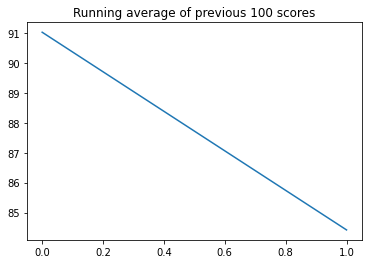

In [11]:
env = make_env("CartPole-v1")
action_space = [_ for _ in range((env.action_space.n))]
n_actions = len(action_space)
input_dims = env.observation_space.shape
noe = 1000 
print(input_dims, n_actions)
max_steps = 1000000
video_prefix = "actor_critic"
is_tg = True 
record = True
lr1 = 1e-4
lr2 = 1e-4
gamma = 0.95
chpkt = 'models/'
algo_name = "actor_critic"

if __name__ == "__main__": 
  
  trainer = Trainer(env, action_space, input_dims, n_actions, video_prefix, is_tg, noe, max_steps, record, lr1, lr2, gamma, chpkt, algo_name)
  ep_rewards = trainer.train()
  plot_learning_curve(ep_rewards, "actor_critic.png")

In [13]:
import pickle 

with open("actor_critic_eps_rewards.obj", "wb") as f: 
  pickle.dump(ep_rewards[0], f)

with open("actor_critic_avg_rewards.obj", "wb") as f: 
  pickle.dump(ep_rewards[1], f)

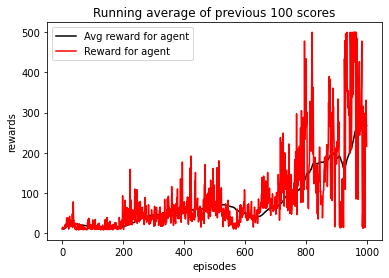

In [43]:
plot_learning_curve(ep_rewards[0], "actor_critic.png")

In [17]:
def greedy_policy(observation, q_val_network, action_space): 
    state = tf.convert_to_tensor([observation])
    actions = q_val_network(state)
    action = tf.math.argmax(actions, axis=1).numpy()[0]
    return action

In [25]:
import random 

class Eval: 

    def __init__(self, env, model_path, number_of_episode=50):
        self.env = env 
        self.model = tf.keras.models.load_model(model_path)
        self.recorder = RecordVideo('dqn_lunarlander', 'test_videos/', 15)
        self.number_of_episode = number_of_episode
        
    def test(self): 
        rewards = []
        steps = []
        for episode in range(self.number_of_episode): 
            done = False
            reward = 0
            step = 0
            state = env.reset(seed=random.randint(0,500))
            if episode % 10 == 0: 
                img = env.render()
                self.recorder.add_image(img) 

            while not done:

                if type(state) == tuple: 
                  state = state[0]
                action =  greedy_policy(state, self.model, action_space)
                state, reward_prob, terminated, truncated, _ = env.step(action)
                done = terminated or truncated 
                reward += reward_prob
                step += 1 
                if episode % 10 == 0:
                    img = env.render()
                    self.recorder.add_image(img)
            
            rewards.append(reward)
            steps.append(step)
            self.recorder.save(1) if episode % 10 == 0 else None 
        
        return rewards, steps


In [26]:
evaluator = Eval(env, "/content/models/_actor_critic_actor_network", 10)
evaluator.test()

([391.0, 495.0, 500.0, 463.0, 500.0, 423.0, 500.0, 500.0, 453.0, 485.0],
 [391, 495, 500, 463, 500, 423, 500, 500, 453, 485])